In [25]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

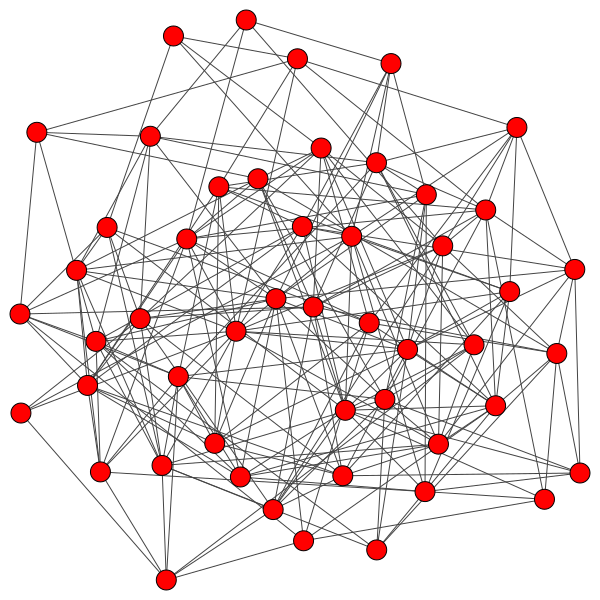

In [35]:
#instance

#inst_="karate"
#G = nx.karate_club_graph()

#inst_="sudoku"
#G = nx.sudoku_graph(50)

#inst_="random_tree"
#G = nx.random_tree(50)

inst_="erdos"
GI = ig.Graph.Erdos_Renyi(n=50, p=0.2, directed=False, loops=False)
A = ig.Graph.get_edgelist(GI)
#G = nx.DiGraph(A)
G = nx.Graph(A)
#G = ig.Graph.to_networkx(GI)
ig.plot(GI)

#inst_="random_internet_100"
#G = nx.random_internet_as_graph(100)

# erdos_renyi_graph(n, p, seed=None, directed=False)
#G = nx.erdos_renyi_graph(50,0.1)

# barabasi_albert_graph(n, m, seed=None, initial_graph=None)
#G = nx.barabasi_albert_graph()

#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)


In [27]:
nx.is_connected(G)

True

In [28]:
#if (0,1) in G.edges:
#    print("yes")
#else:
#    print("no")

#for e in G.edges:
#    (u,w) = e
#    print(u, w, e)

In [29]:
#print(list(G.nodes))
#print(list(G.edges))
#list(G.adj[1])  # or list(G.neighbors(1))
#G.degree[1]  # the number of edges incident to 1
#G[1]  # same as G.adj[1]
#nx.maximal_independent_set(G) 

In [30]:
#N = nx.neighbors(G,1)
#for i in N:
#    print(i)

In [31]:
#path = nx.single_source_dijkstra_path(G, 0)
#path

In [32]:
#nx.draw(G, with_labels=True)
#plt.show()

In [33]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

#G.edges


In [22]:
# form0
form_="form0"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status_ = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MINIMIZE)
    
    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0
 
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1*x[i]
    model.addConstr(constr0 == 1)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 >= x[s])

    #x[i].Start = 1.0
    #relax = model.relax()    
    #relax.optimize()
    
    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-01
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


In [23]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1